In [1]:
import os, sys, glob
import json, csv, bz2, re, datetime
import pickle
import collections
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm as cm
from tqdm import tqdm
from collections import Counter

from dir_build_dataset_tweets import read_vids

In [2]:
dataset_base = "G:/MLCV dataset/ACTIVE/active-dataset.json.bz2"

attributes = ["YoutubeID","numTweet","numShare","numSubscriber","watchTime","dailyViewcount",\
              "description","title","channelId","channelTitle","category","uploadDate","duration",\
              "definition","dimension","caption","regionRestriction.blocked",\
              "regionRestriction.allowed","topicIds","relevantTopicIds","totalShare",\
              "totalViewcount","totalTweet","dailyTweets"]

In [3]:
with bz2.BZ2File(dataset_base) as f:
    dataset = json.loads(f.readline())
    
print(len(dataset))
print("Max history 237 days")

# dataset: [{attr -> val}]

14041
Max history 237 days


In [7]:
def get_diff_tweets_vs_viewcount(dataset):    
    diff_tweetsToViewcount = {
        "vids": [],
        "day_zero": [],
        "last_day": [],
        "length": []
    }
    
    for entry in dataset:
        vid = entry["YoutubeID"]       
        tweets_series = entry["dailyTweets"]
        viewcount_series = entry["dailyViewcount"]

        tweets_info = [None, None, 0]
        viewcount_info = [None, None, 0]
        for i in range(len(tweets_series)):
            if (type(tweets_series[i]) == int or type(tweets_series[i]) == float) and tweets_series[i] >0:
                if tweets_info[0] is None: tweets_info[0] = i
                tweets_info[1] = i
                tweets_info[2] += 1
                
            if (type(viewcount_series[i]) == int or type(viewcount_series[i]) == float) and viewcount_series[i] >0:
                if viewcount_info[0] is None: viewcount_info[0] = i
                viewcount_info[1] = i
                viewcount_info[2] += 1 

        diff_tweetsToViewcount['vids'].append(vid)    
        diff_tweetsToViewcount['day_zero'].append(tweets_info[0]-viewcount_info[0])
        diff_tweetsToViewcount['last_day'].append(tweets_info[1]-viewcount_info[1])
        diff_tweetsToViewcount['length'].append(tweets_info[2]-viewcount_info[2])
        
#         if tweets_info[1]-viewcount_info[1] < -200:
#             print(vid)
#             print(tweets_series)
#             print(viewcount_series)
        
    return diff_tweetsToViewcount

In [8]:
def display_diff(test_category, diff_tweetsToEngage, save_base='figs/tmp/'):
    Cnt = Counter(diff_tweetsToEngage["day_zero"])
    most_common_diff = [
        [diff for diff, _ in Cnt.most_common(10)], 
        [cnt  for _, cnt in Cnt.most_common(10)], 
        ["{:.3f}".format(cnt/len(diff_tweetsToEngage['vids'])) for diff, cnt in Cnt.most_common(10)]
    ]    
    
    df = pd.DataFrame(most_common_diff[1:], columns = most_common_diff[0])
    print("Top 10 difference at `day_zero` ({})".format(test_category))
    display(df)
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    bin_width = 50
    bins = [x for x in range(min(diff_tweetsToEngage["last_day"])//bin_width*bin_width,
                             max(diff_tweetsToEngage["last_day"])//bin_width*bin_width+bin_width, bin_width)]
    ax.hist(diff_tweetsToEngage["last_day"], rwidth=0.9, bins=bins, log=True)
    ax.set_ylim(bottom=1)
    ax.set_xticks(bins)
    ax.set_title("`last_day` difference between tweets and viewcounts in ACTIVE ({})".format(test_category))
    ax.set_xlabel("`last_day` difference")
    ax.set_ylabel("Num. videos (log)")
    plt.savefig(save_base+"last_day({}, logY)".format(test_category))
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    bin_width = 50
    bins = [x for x in range(min(diff_tweetsToEngage["length"])//bin_width*bin_width,
                             max(diff_tweetsToEngage["length"])//bin_width*bin_width+bin_width, bin_width)]
    ax.hist(diff_tweetsToEngage["length"], rwidth=0.9, bins=bins, log=True)
    ax.set_ylim(bottom=1)
    ax.set_xticks(bins)
    ax.set_title("`length` difference between tweets and viewcounts in ACTIVE ({})".format(test_category))
    ax.set_xlabel("`last_day` difference")
    ax.set_ylabel("Num. videos (log)")    
    plt.savefig(save_base+"length({}, logY)".format(test_category))

Top 10 difference at `day_zero` (all_cats)


,0,1,2,3,5,4,6,8,10,7
0,13266,344,105,60,35,35,24,19,17,15
1,0.945,0.024,0.007,0.004,0.002,0.002,0.002,0.001,0.001,0.001


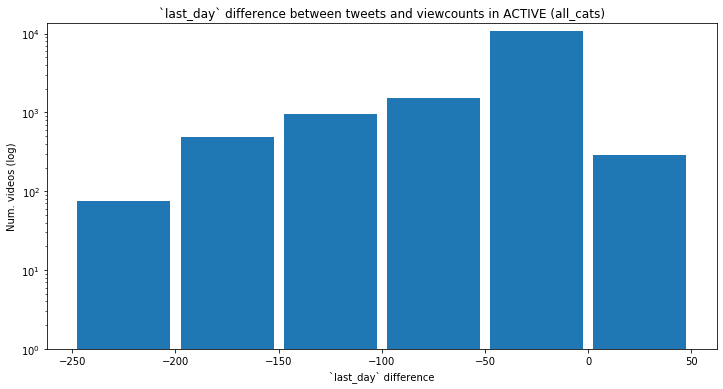

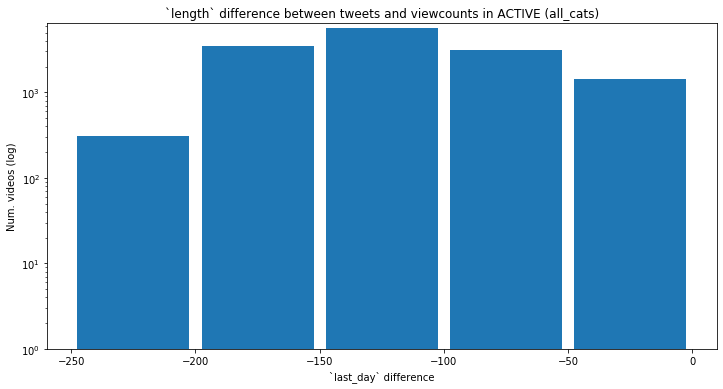

In [9]:
diff = get_diff_tweets_vs_viewcount(dataset)
display_diff("all_cats", diff, "figs/ACTIVE/")